<Axes: xlabel='lat', ylabel='lon'>

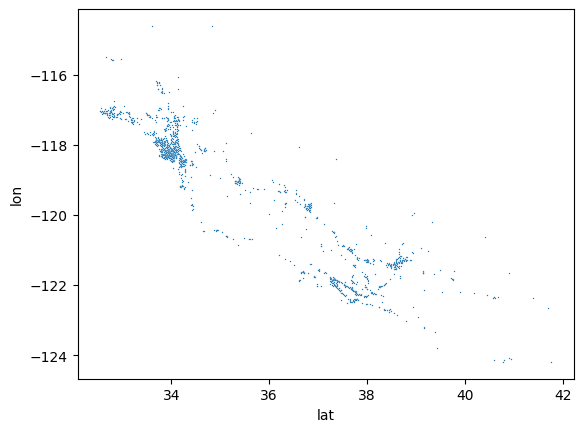

In [30]:
import pandas as pd
import seaborn as sns

mac = pd.read_csv("data/mcdonalds/v.csv", names=["lat", "lon"])
mac["type"] = "mac"
sns.scatterplot(data=mac, x="lat", y="lon", s=1)

# all = pd.concat([housing, mac])
# sns.scatterplot(data=all, x="lat", y="lon",hue="type",)

<Axes: xlabel='lat', ylabel='lon'>

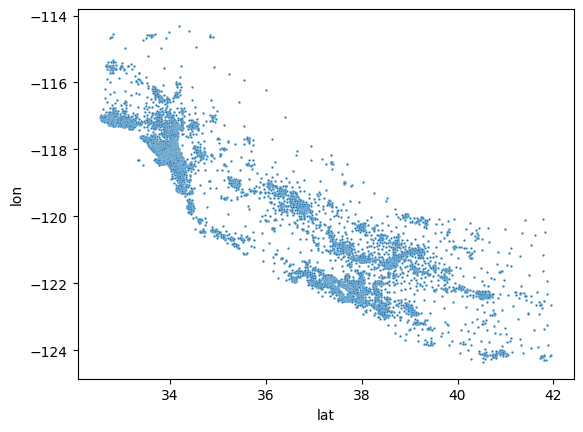

In [32]:
housing = pd.read_csv("data/housing/v.csv", names=["lat", "lon"])
housing["type"] = "housing"
sns.scatterplot(data=housing, x="lat", y="lon", s=3)